<a href="https://colab.research.google.com/github/gabrielvinicios02/ExperimentsMultivariate/blob/f-predictDiagrama/ClassificadorXGBoost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Séries Temporais


<center>
<table><tr><td> <a href="http://www.minds.eng.ufmg.br/"><img src="https://github.com/petroniocandido/pyFTS/raw/master/img/minds_logo_medium.jpeg" alt="MINDS - Machine Intelligence and Data Science Lab" width="100"/></a></td> 
  <td>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;</td>
<td><a href="https://pyfts.github.io/pyFTS/"><img src="https://github.com/petroniocandido/pyFTS/raw/master/img/logo_medium.png" alt="pyFTS - Fuzzy Time Series for Python" width="100"/></a></td>
</tr>
</table>
</center>

In [9]:
!pip3 install -U git+https://github.com/PYFTS/pyFTS
#!pip3 install -U pyFTS
!pip3 install SimpSOM
!pip install dispy
#!pip install matplotlib==3.1.3
!pip install matplotlib==3.1.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/PYFTS/pyFTS to /tmp/pip-req-build-lsrhmszl
  Running command git clone -q https://github.com/PYFTS/pyFTS /tmp/pip-req-build-lsrhmszl
  Created wheel for pyFTS: filename=pyFTS-1.6-py3-none-any.whl size=217208 sha256=fc0649fbac37d5d06dedd99fb35f0f6453517230411d853999cc96065d8859e5
  Stored in directory: /tmp/pip-ephem-wheel-cache-lc7t9rjs/wheels/30/23/2b/2e10c811e284f08e37b5f6d6320e78bade4dd580081288f61a
Successfully built pyFTS
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 11.2 MB 15.2 MB/s 
     |████████████████████████████████| 944 kB 60.0 MB/s 
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.2.2
    Uninstalling matplotlib-3.2.2:
      Successfully uninstalled matplotlib-3.2.2


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 426 kB 15.6 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
  Using cached pycos-4.12.1-py3-none-any.whl
  Created wheel for dispy: filename=dispy-4.15.1-py3-none-any.whl size=213151 sha256=1669e4536d78cbf08062c85662276ac1f4bf9ab47b9c621cc211acc504d0d517
  Stored in directory: /root/.cache/pip/wheels/74/a9/a9/da60ca2929aa2f5df2ee4b19a3b509d5fad720442045da22d1
Successfully built dispy
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 13.1 MB 14.6 MB/s 
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.5.2
    Uninstalling matplotlib-3.5.2:
      Successfully uninstalled matplotlib-3.5.2
ERROR: pip's dependen

In [10]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib as plt
import matplotlib.pyplot as plt
from pyFTS.models import hofts
from pyFTS.partitioners import Grid
from pyFTS.benchmarks import Measures

In [11]:
from pyFTS.data import TAIEX, Malaysia, sunspots, artificial
from statsmodels.tsa.stattools import acf, pacf

datasets = {}

dff = pd.read_excel('../content/drive/MyDrive/DadosPWFTS/DadosFalha.xlsx')
dfn = pd.read_excel('../content/drive/MyDrive/DadosPWFTS/DadosNormais.xlsx')

dados_treino_Falha = dff[0:2300] 
dados_teste_Falha = dff[1800:2300]

dados_treino_Normal = dfn[0:1800] 
dados_teste_Normal = dfn[1500:1800]

In [12]:
print(dados_treino_Falha)

                    Data  LIT_2012KS_0251_FilteredSignal  \
0    2021-12-05 08:50:13                       35.298019   
1    2021-12-05 08:51:25                       69.698112   
2    2021-12-05 08:52:37                       86.492775   
3    2021-12-05 08:53:49                       87.605766   
4    2021-12-05 08:55:01                       87.592270   
...                  ...                             ...   
2295 2021-12-09 22:55:01                       39.161282   
2296 2021-12-09 22:56:13                       34.402630   
2297 2021-12-09 22:57:25                       29.267023   
2298 2021-12-09 22:58:37                       24.829168   
2299 2021-12-09 22:59:49                       18.879450   

      _AL_2012KS_06M1_SpeedActual  WIT_1085KS_2300_BeltLoad  \
0                        0.000000                604.000305   
1                        0.000000                594.372681   
2                        0.000000                548.985413   
3                        0.

In [13]:
print(dados_treino_Normal)

                    Data  LIT_2012KS_0251_FilteredSignal  \
0    2021-12-05 07:20:13                        2.832069   
1    2021-12-05 07:21:25                        4.418116   
2    2021-12-05 07:22:37                       22.953905   
3    2021-12-05 07:23:49                       33.815975   
4    2021-12-05 07:25:01                       33.374435   
...                  ...                             ...   
1795 2021-12-07 02:38:13                       11.774282   
1796 2021-12-07 02:39:25                        4.781181   
1797 2021-12-07 02:40:37                        3.563411   
1798 2021-12-07 02:41:49                        3.671766   
1799 2021-12-07 02:43:01                        3.691521   

      _AL_2012KS_06M1_SpeedActual  WIT_1085KS_2300_BeltLoad  \
0                        0.000000                295.496826   
1                        0.000000                321.693665   
2                       14.761859                337.279755   
3                       71.

In [14]:
print(dados_teste_Falha)

                    Data  LIT_2012KS_0251_FilteredSignal  \
1800 2021-12-08 22:32:13                       68.584373   
1801 2021-12-08 22:33:25                       79.267204   
1802 2021-12-08 22:34:37                       74.231430   
1803 2021-12-08 22:35:49                       67.143143   
1804 2021-12-08 22:37:01                       56.879524   
...                  ...                             ...   
2295 2021-12-09 22:55:01                       39.161282   
2296 2021-12-09 22:56:13                       34.402630   
2297 2021-12-09 22:57:25                       29.267023   
2298 2021-12-09 22:58:37                       24.829168   
2299 2021-12-09 22:59:49                       18.879450   

      _AL_2012KS_06M1_SpeedActual  WIT_1085KS_2300_BeltLoad  \
1800                    36.922737                551.704773   
1801                    51.525627                551.704529   
1802                    59.430199                551.716675   
1803                    59.

In [15]:
print(dados_teste_Normal)

                    Data  LIT_2012KS_0251_FilteredSignal  \
1500 2021-12-08 09:28:37                       43.040955   
1501 2021-12-08 09:29:49                       37.851479   
1502 2021-12-08 09:31:01                       32.487022   
1503 2021-12-08 09:32:13                       27.220686   
1504 2021-12-08 09:33:25                       22.106337   
...                  ...                             ...   
1795 2021-12-07 02:38:13                       11.774282   
1796 2021-12-07 02:39:25                        4.781181   
1797 2021-12-07 02:40:37                        3.563411   
1798 2021-12-07 02:41:49                        3.671766   
1799 2021-12-07 02:43:01                        3.691521   

      _AL_2012KS_06M1_SpeedActual  WIT_1085KS_2300_BeltLoad  \
1500                    59.528919                297.226349   
1501                    59.413948                246.993668   
1502                    59.192154                220.550995   
1503                    59.

## Analisando as Séries Temporais

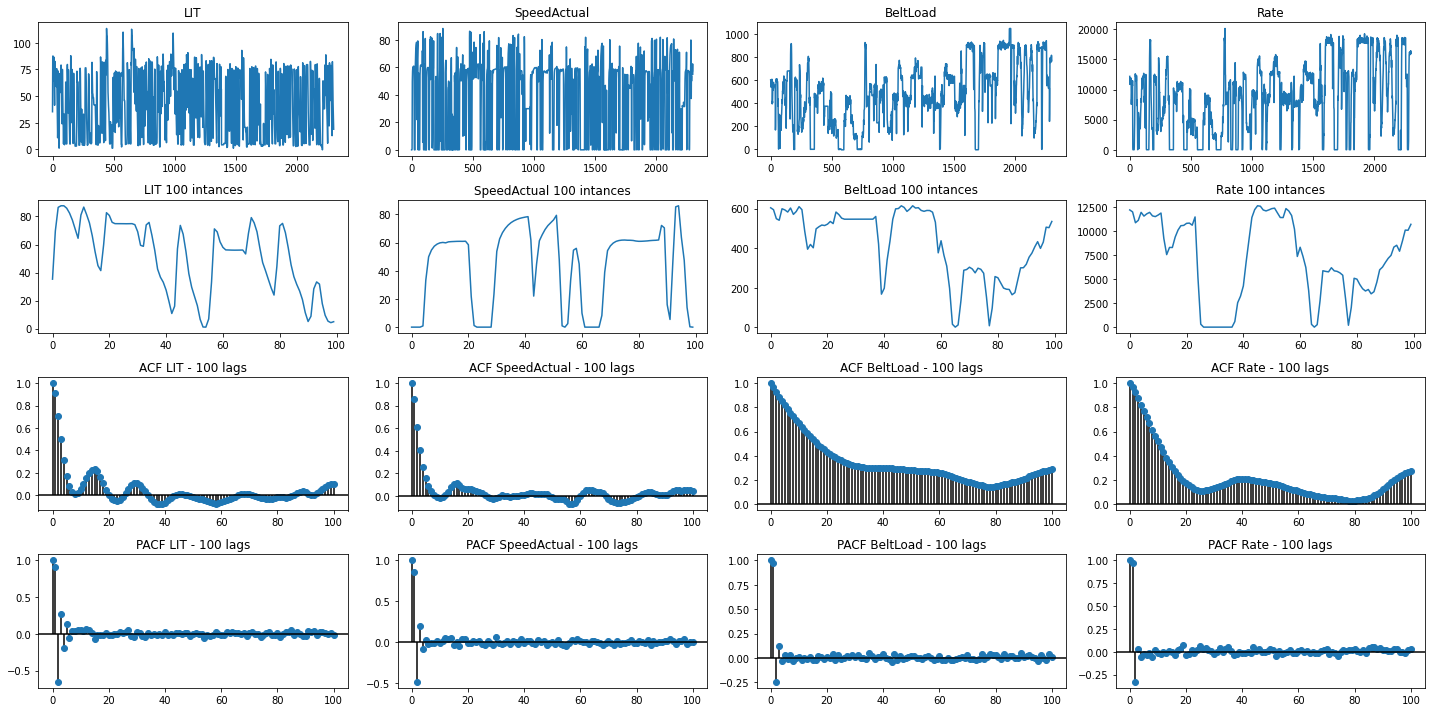

In [16]:
#Dados com Falhas

from pyFTS.data import TAIEX, Malaysia, sunspots, artificial
from statsmodels.tsa.stattools import acf, pacf

datasets1 = {}

datasets1['LIT'] = dados_treino_Falha.get('LIT_2012KS_0251_FilteredSignal')
datasets1['SpeedActual'] = dados_treino_Falha.get('_AL_2012KS_06M1_SpeedActual')
datasets1['BeltLoad'] = dados_treino_Falha.get('WIT_1085KS_2300_BeltLoad')
datasets1['Rate'] = dados_treino_Falha.get('WIT_1085KS_2300_Rate')


fig1, ax = plt.subplots(nrows=4, ncols=4, figsize=[20,10])

for ct, (key, data) in enumerate(datasets1.items()): 
  _lags = np.arange(0,101)
  _acf = acf(data,nlags=100)
  _pacf = pacf(data,nlags=100)
  
  ax[0][ct].set_title("{}".format(key))
  ax[0][ct].plot(data)
  
  ax[1][ct].set_title("{} 100 intances".format(key))
  ax[1][ct].plot(data[:100])
  
  ax[2][ct].set_title("ACF {} - 100 lags".format(key))
  ax[2][ct].plot(_lags, _acf, "o")
  ax[2][ct].vlines(_lags,[0],_acf)
  ax[2][ct].axhline(y=0, color='black')
  
  ax[3][ct].set_title("PACF {} - 100 lags".format(key))
  ax[3][ct].plot(_lags, _pacf, "o")
  ax[3][ct].vlines(_lags,[0],_pacf)
  ax[3][ct].axhline(y=0, color='black')

plt.tight_layout()

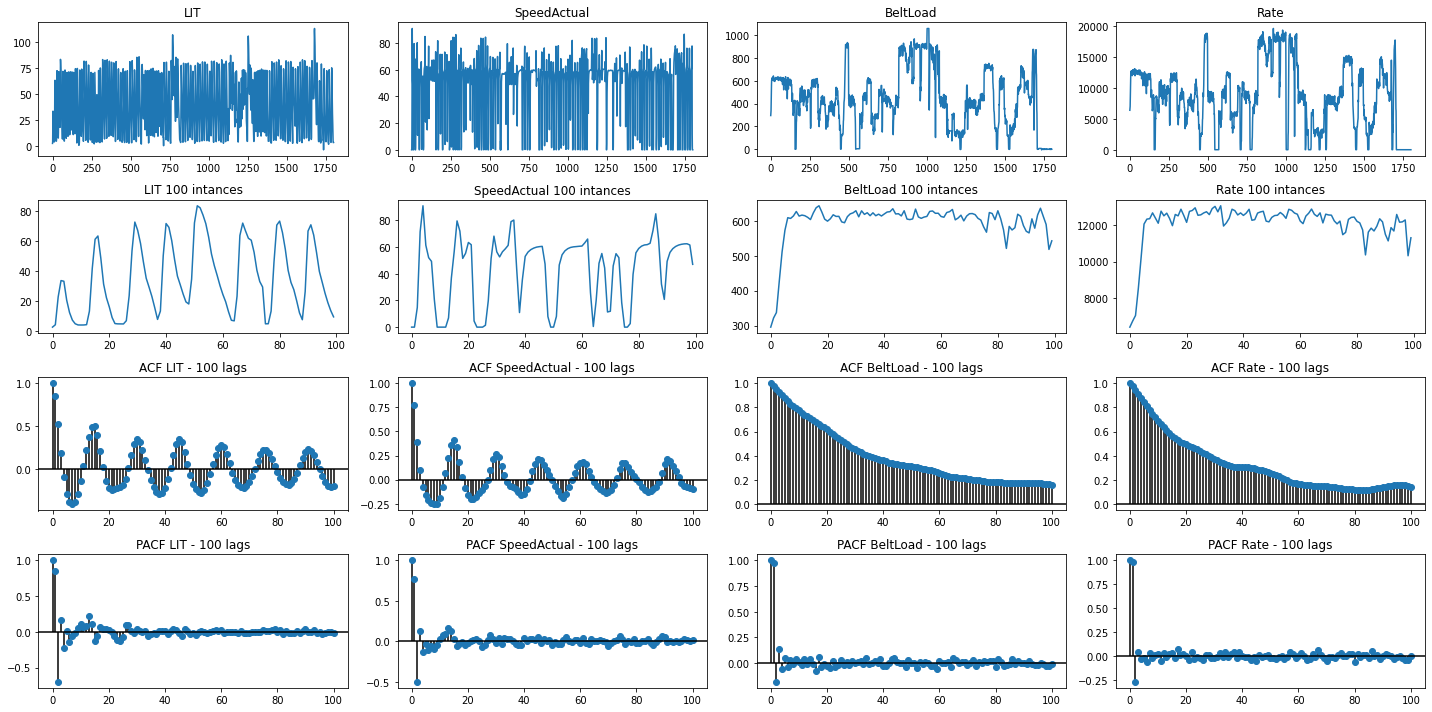

In [17]:
#Dados normais - sem falhas
from pyFTS.data import TAIEX, Malaysia, sunspots, artificial
from statsmodels.tsa.stattools import acf, pacf

datasets2 = {}

datasets2['LIT'] = dados_treino_Normal.get('LIT_2012KS_0251_FilteredSignal')
datasets2['SpeedActual'] = dados_treino_Normal.get('_AL_2012KS_06M1_SpeedActual')
datasets2['BeltLoad'] = dados_treino_Normal.get('WIT_1085KS_2300_BeltLoad')
datasets2['Rate'] = dados_treino_Normal.get('WIT_1085KS_2300_Rate')


fig2, ax = plt.subplots(nrows=4, ncols=4, figsize=[20,10])

for ct, (key, data) in enumerate(datasets2.items()): 
  _lags = np.arange(0,101)
  _acf = acf(data,nlags=100)
  _pacf = pacf(data,nlags=100)
  
  ax[0][ct].set_title("{}".format(key))
  ax[0][ct].plot(data)
  
  ax[1][ct].set_title("{} 100 intances".format(key))
  ax[1][ct].plot(data[:100])
  
  ax[2][ct].set_title("ACF {} - 100 lags".format(key))
  ax[2][ct].plot(_lags, _acf, "o")
  ax[2][ct].vlines(_lags,[0],_acf)
  ax[2][ct].axhline(y=0, color='black')
  
  ax[3][ct].set_title("PACF {} - 100 lags".format(key))
  ax[3][ct].plot(_lags, _pacf, "o")
  ax[3][ct].vlines(_lags,[0],_pacf)
  ax[3][ct].axhline(y=0, color='black')

plt.tight_layout()

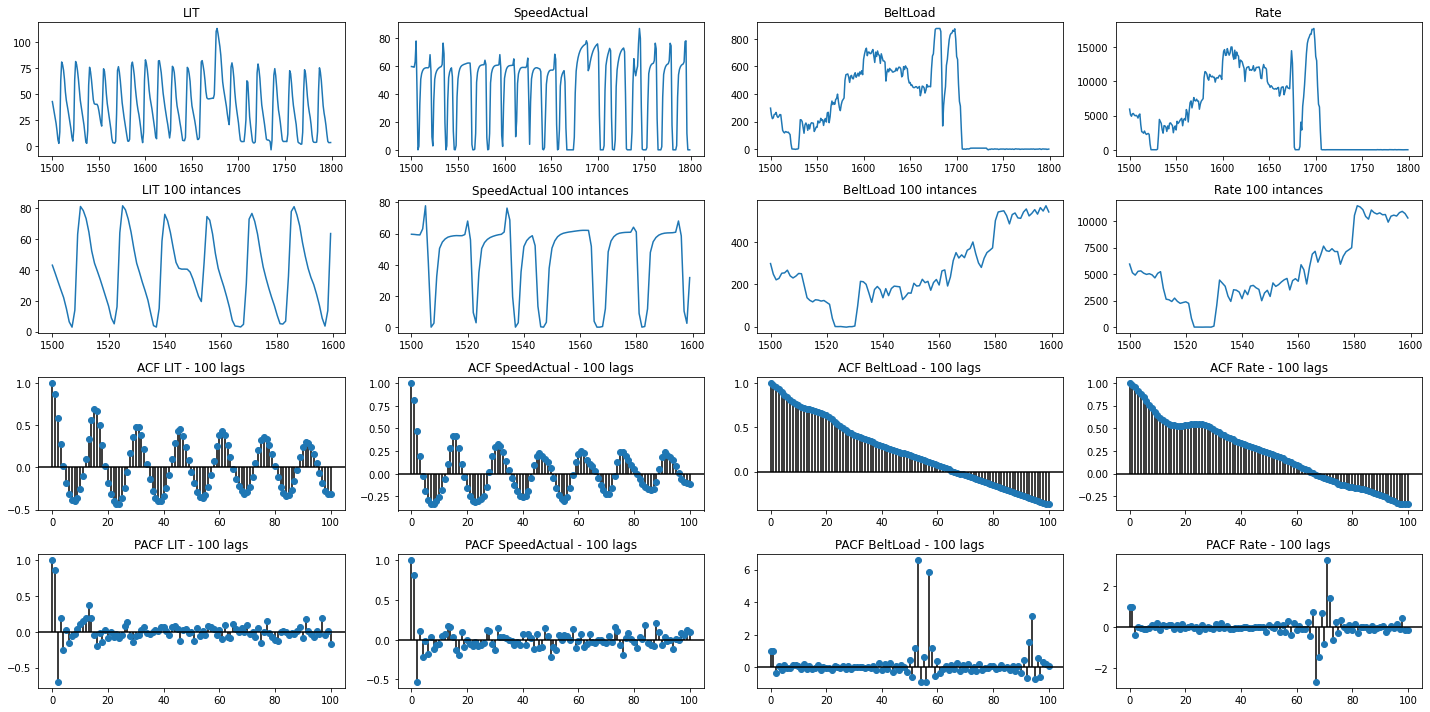

In [18]:
#Dados normais - sem falhas
from pyFTS.data import TAIEX, Malaysia, sunspots, artificial
from statsmodels.tsa.stattools import acf, pacf

datasets3 = {}

datasets3['LIT'] = dados_teste_Normal.get('LIT_2012KS_0251_FilteredSignal')
datasets3['SpeedActual'] = dados_teste_Normal.get('_AL_2012KS_06M1_SpeedActual')
datasets3['BeltLoad'] = dados_teste_Normal.get('WIT_1085KS_2300_BeltLoad')
datasets3['Rate'] = dados_teste_Normal.get('WIT_1085KS_2300_Rate')


fig3, ax = plt.subplots(nrows=4, ncols=4, figsize=[20,10])

for ct, (key, data) in enumerate(datasets3.items()): 
  _lags = np.arange(0,101)
  _acf = acf(data,nlags=100)
  _pacf = pacf(data,nlags=100)
  
  ax[0][ct].set_title("{}".format(key))
  ax[0][ct].plot(data)
  
  ax[1][ct].set_title("{} 100 intances".format(key))
  ax[1][ct].plot(data[:100])
  
  ax[2][ct].set_title("ACF {} - 100 lags".format(key))
  ax[2][ct].plot(_lags, _acf, "o")
  ax[2][ct].vlines(_lags,[0],_acf)
  ax[2][ct].axhline(y=0, color='black')
  
  ax[3][ct].set_title("PACF {} - 100 lags".format(key))
  ax[3][ct].plot(_lags, _pacf, "o")
  ax[3][ct].vlines(_lags,[0],_pacf)
  ax[3][ct].axhline(y=0, color='black')

plt.tight_layout()

,Partitions,RMSE,MAPE,U
0,Grid,15.94,inf,1.13


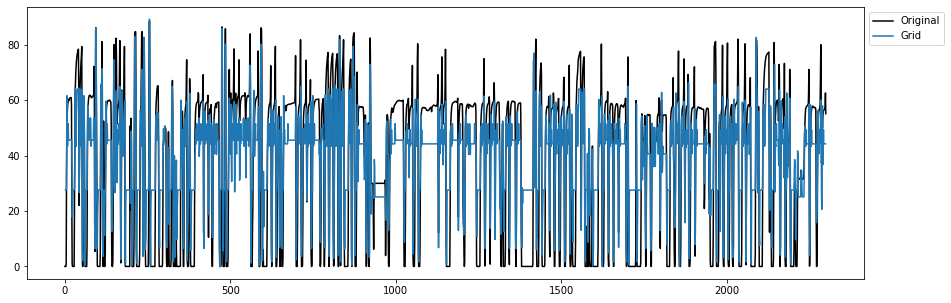

In [19]:
from pyFTS.models import hofts
from pyFTS.partitioners import Grid, FCM, CMeans, Entropy
from pyFTS.benchmarks import Measures

metodos = [Grid.GridPartitioner]#, Entropy.EntropyPartitioner, CMeans.CMeansPartitioner ]

k = 30

rows = []

y1=np.asarray(datasets1['SpeedActual'])

fig, ax = plt.subplots(nrows=1, ncols=1,figsize=[15,5])

ax.plot(y1, label='Original',color='black')

for contador, metodo in enumerate(metodos):
  part = metodo(data=y1, npart=k)
  model = hofts.HighOrderFTS(order=2, partitioner=part)
  model.fit(y1)
  forecasts = model.predict(y1)
  for o in range(model.order):
    forecasts.insert(0,None)
    
  ax.plot(forecasts[:-1], label=part.name)
  
  rmse, mape, u = Measures.get_point_statistics(y1, model)
  
  rows.append([part.name, rmse, mape, u])
  

handles, labels = ax.get_legend_handles_labels()
lgd = ax.legend(handles, labels, loc=2, bbox_to_anchor=(1, 1))

pd.DataFrame(rows, columns=['Partitions','RMSE','MAPE','U'])

In [20]:
#Dados Sem Falhas
from numpy.core.multiarray import concatenate
from pyFTS.models import pwfts
#from pyFTS.models import chen, cheng, hofts, pwfts
from pyFTS.partitioners import Grid
from pyFTS.benchmarks import Measures
from pyFTS.common import Util

#metodos = [chen.ConventionalFTS, cheng.TrendWeightedFTS, hofts.HighOrderFTS, 
#          hofts.WeightedHighOrderFTS, pwfts.ProbabilisticWeightedFTS]
metodos = [pwfts.ProbabilisticWeightedFTS]

k = 10
y1 = datasets2['LIT']
tam_grupo = 100
i=0
VT1=[]

for i in range(0,y1.size,tam_grupo):
  grpan = y1[i:i+tam_grupo]
  part = Grid.GridPartitioner(data=np.asarray(grpan), npart=k)
  for contador, metodo in enumerate(metodos):
    model1 = metodo(partitioner=part, progress=False, type='distribution')
    if model1.is_high_order:
      model1 = metodo(partitioner=part, order=1)
    model1.fit(np.asarray(y1))  
  #print(model1)
  _, _, lhs1, rhs1 = pwfts.highorder_fuzzy_markov_chain(model1)
  lhs1t = np.transpose(lhs1)
  V1 = np.c_[rhs1,lhs1t]
  if i == 0 :
    VT1 = V1
  else:
    VT1 = np.c_[VT1,V1]

  print(i)

VT1 = np.transpose(VT1)
print(VT1)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
[[5.20794937e-01 3.51428679e-01 5.56970061e-02 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [2.54046046e-01 3.24619755e-01 4.19192769e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [1.04892244e-01 8.12349134e-02 2.95153727e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [0.00000000e+00 4.42045046e-04 1.98139176e-02 ... 7.39487566e-02
  2.93760453e-01 4.35476043e-01]
 [0.00000000e+00 0.00000000e+00 1.38999388e-04 ... 1.11303577e-01
  1.45131010e-01 4.54841208e-01]
 [1.25927486e-02 1.43671356e-01 1.12357775e-01 ... 8.13692130e-02
  1.12407682e-01 9.46322200e-02]]


In [21]:
#Dados Sem Falhas
from pyFTS.models import pwfts
#from pyFTS.models import chen, cheng, hofts, pwfts
from pyFTS.partitioners import Grid
from pyFTS.benchmarks import Measures

#metodos = [chen.ConventionalFTS, cheng.TrendWeightedFTS, hofts.HighOrderFTS, 
#          hofts.WeightedHighOrderFTS, pwfts.ProbabilisticWeightedFTS]
metodos = [pwfts.ProbabilisticWeightedFTS]

k = 10
y2 = datasets2['SpeedActual']
tam_grupo = 100
i=0
VT2=[]
V2=[]

for i in range(0,y2.size,tam_grupo):
  grpan = y2[i:i+tam_grupo]
  part = Grid.GridPartitioner(data=np.asarray(grpan), npart=k)
  for contador, metodo in enumerate(metodos):
    model2 = metodo(partitioner=part, progress=False, type='distribution')
    if model2.is_high_order:
      model2 = metodo(partitioner=part, order=1)
    model2.fit(np.asarray(y2))  
  #print(model1)
  _, _, lhs2, rhs2 = pwfts.highorder_fuzzy_markov_chain(model2)
  lhs2t = np.transpose(lhs2)
  V2 = np.c_[rhs2,lhs2t]
  if i == 0 :
    VT2 = V2
  else:
    VT2 = np.c_[VT2,V2]

  print(i)

VT2 = np.transpose(VT2)
print(VT2)



0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
[[0.63564032 0.29436782 0.3731472  ... 0.00272307 0.00210211 0.        ]
 [0.15964179 0.05136032 0.04394166 ... 0.01063507 0.0232674  0.        ]
 [0.07223026 0.0372693  0.02773656 ... 0.00872978 0.07065097 0.02979623]
 ...
 [0.         0.00327941 0.00536503 ... 0.12503673 0.31247289 0.18711122]
 [0.         0.         0.         ... 0.0244453  0.10015853 0.21388117]
 [0.11498654 0.03762983 0.02782005 ... 0.14868944 0.04616166 0.01176464]]


In [22]:
#Dados Sem Falhas
from pyFTS.models import pwfts
#from pyFTS.models import chen, cheng, hofts, pwfts
from pyFTS.partitioners import Grid
from pyFTS.benchmarks import Measures

#metodos = [chen.ConventionalFTS, cheng.TrendWeightedFTS, hofts.HighOrderFTS, 
#          hofts.WeightedHighOrderFTS, pwfts.ProbabilisticWeightedFTS]
metodos = [pwfts.ProbabilisticWeightedFTS]

k = 10
y3 = datasets2['BeltLoad']
tam_grupo = 100
i=0
VT3=[]
V3=[]

for i in range(0,y3.size,tam_grupo):
  grpan = y3[i:i+tam_grupo]
  part = Grid.GridPartitioner(data=np.asarray(grpan), npart=k)
  for contador, metodo in enumerate(metodos):
    model3 = metodo(partitioner=part, progress=False, type='distribution')
    if model3.is_high_order:
      model3 = metodo(partitioner=part, order=1)
    model3.fit(np.asarray(y3))  
  #print(model1)
  _, _, lhs3, rhs3 = pwfts.highorder_fuzzy_markov_chain(model3)
  lhs3t = np.transpose(lhs3)
  V3 = np.c_[rhs3,lhs3t]
  if i == 0 :
    VT3 = V3
  else:
    VT3 = np.c_[VT3,V3]

  print(i)

VT3 = np.transpose(VT3)
print(VT3)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
[[9.20681137e-01 2.51696630e-01 5.22246875e-02 ... 5.31317503e-03
  0.00000000e+00 0.00000000e+00]
 [5.78969575e-02 4.26303091e-01 1.88782603e-01 ... 5.84697498e-03
  0.00000000e+00 6.55735826e-04]
 [1.13428586e-02 2.31732341e-01 3.23712512e-01 ... 3.54948115e-03
  6.94309771e-04 2.42658750e-03]
 ...
 [0.00000000e+00 1.10686275e-02 2.52114605e-03 ... 2.06152737e-01
  6.44491068e-01 1.21990924e-01]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 2.77609124e-02
  1.92837671e-01 8.52151590e-01]
 [8.03893756e-02 1.96368688e-02 7.25096338e-02 ... 8.74179489e-02
  1.24102350e-01 1.89845955e-01]]


In [23]:
#Dados Sem Falhas
from pyFTS.models import pwfts
#from pyFTS.models import chen, cheng, hofts, pwfts
from pyFTS.partitioners import Grid
from pyFTS.benchmarks import Measures

#metodos = [chen.ConventionalFTS, cheng.TrendWeightedFTS, hofts.HighOrderFTS, 
#          hofts.WeightedHighOrderFTS, pwfts.ProbabilisticWeightedFTS]
metodos = [pwfts.ProbabilisticWeightedFTS]

k = 10
y4 = datasets2['Rate']
tam_grupo = 100
i=0
VT4=[]
V4=[]

for i in range(0,y4.size,tam_grupo):
  grpan = y4[i:i+tam_grupo]
  part = Grid.GridPartitioner(data=np.asarray(grpan), npart=k)
  for contador, metodo in enumerate(metodos):
    model4 = metodo(partitioner=part, progress=False, type='distribution')
    if model4.is_high_order:
      model4 = metodo(partitioner=part, order=1)
    model4.fit(np.asarray(y4))  
  #print(model1)
  _, _, lhs4, rhs4 = pwfts.highorder_fuzzy_markov_chain(model4)
  lhs4t = np.transpose(lhs4)
  V4 = np.c_[rhs4,lhs4t]
  if i == 0 :
    VT4 = V4
  else:
    VT4 = np.c_[VT4,V4]

  print(i)

VT4 = np.transpose(VT4)
print(VT4)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
[[9.33144994e-01 2.56247660e-01 7.65074889e-02 ... 5.98855671e-04
  1.29962181e-03 2.91582981e-03]
 [4.50477132e-02 4.04034550e-01 1.48157460e-01 ... 2.63121732e-03
  1.72389391e-03 0.00000000e+00]
 [1.52275711e-02 2.43140157e-01 3.33306443e-01 ... 3.39476915e-03
  9.47974609e-03 2.57574643e-03]
 ...
 [0.00000000e+00 1.30614977e-03 4.63955056e-04 ... 2.09091982e-01
  6.64805202e-01 1.13634687e-01]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 3.63968745e-02
  1.68371034e-01 8.61279592e-01]
 [1.24177092e-01 1.96063079e-02 6.70466707e-02 ... 8.28212667e-02
  1.18494108e-01 1.77687454e-01]]


In [24]:
#Dados Com Falhas
from numpy.core.multiarray import concatenate
from pyFTS.models import pwfts
#from pyFTS.models import chen, cheng, hofts, pwfts
from pyFTS.partitioners import Grid
from pyFTS.benchmarks import Measures
from pyFTS.common import Util

#metodos = [chen.ConventionalFTS, cheng.TrendWeightedFTS, hofts.HighOrderFTS, 
#          hofts.WeightedHighOrderFTS, pwfts.ProbabilisticWeightedFTS]
metodos = [pwfts.ProbabilisticWeightedFTS]

k = 10
y1 = datasets1['LIT']
tam_grupo = 100
i=0
VU1=[]

for i in range(0,y1.size,tam_grupo):
  grpan = y1[i:i+tam_grupo]
  part = Grid.GridPartitioner(data=np.asarray(grpan), npart=k)
  for contador, metodo in enumerate(metodos):
    model1 = metodo(partitioner=part, progress=False, type='distribution')
    if model1.is_high_order:
      model1 = metodo(partitioner=part, order=1)
    model1.fit(np.asarray(y1))  
  #print(model1)
  _, _, lhs1, rhs1 = pwfts.highorder_fuzzy_markov_chain(model1)
  lhs1t = np.transpose(lhs1)
  V1 = np.c_[rhs1,lhs1t]
  if i == 0 :
    VU1 = V1
  else:
    VU1 = np.c_[VU1,V1]

  print(i)

VU1 = np.transpose(VU1)
print(VU1)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
[[5.55453502e-01 3.77174079e-01 3.65231193e-02 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [3.48420113e-01 3.79223123e-01 3.79472690e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [5.51803956e-02 8.68887655e-02 3.53107324e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [0.00000000e+00 0.00000000e+00 4.98086179e-04 ... 1.40073606e-01
  4.56368345e-01 3.76413338e-01]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 4.50990407e-02
  7.45288048e-02 5.82065559e-01]
 [9.54333949e-02 1.58784913e-01 9.97401002e-02 ... 1.08798565e-01
  1.08116872e-01 4.32795925e-02]]


In [25]:
#Dados Com Falhas
from pyFTS.models import pwfts
#from pyFTS.models import chen, cheng, hofts, pwfts
from pyFTS.partitioners import Grid
from pyFTS.benchmarks import Measures

#metodos = [chen.ConventionalFTS, cheng.TrendWeightedFTS, hofts.HighOrderFTS, 
#          hofts.WeightedHighOrderFTS, pwfts.ProbabilisticWeightedFTS]
metodos = [pwfts.ProbabilisticWeightedFTS]

k = 10
y2 = datasets1['SpeedActual']
tam_grupo = 100
i=0
VU2=[]
V2=[]

for i in range(0,y2.size,tam_grupo):
  grpan = y2[i:i+tam_grupo]
  part = Grid.GridPartitioner(data=np.asarray(grpan), npart=k)
  for contador, metodo in enumerate(metodos):
    model2 = metodo(partitioner=part, progress=False, type='distribution')
    if model2.is_high_order:
      model2 = metodo(partitioner=part, order=1)
    model2.fit(np.asarray(y2))  
  #print(model1)
  _, _, lhs2, rhs2 = pwfts.highorder_fuzzy_markov_chain(model2)
  lhs2t = np.transpose(lhs2)
  V2 = np.c_[rhs2,lhs2t]
  if i == 0 :
    VU2 = V2
  else:
    VU2 = np.c_[VU2,V2]

  print(i)

VU2 = np.transpose(VU2)
print(VU2)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
[[8.16177887e-01 4.79832346e-01 2.93249537e-01 ... 7.58092287e-03
  1.06184803e-03 0.00000000e+00]
 [6.99989808e-02 2.62153497e-02 6.61722120e-02 ... 4.00698714e-02
  1.31724891e-02 0.00000000e+00]
 [4.58404508e-02 4.45765744e-02 4.41786795e-02 ... 2.66471297e-02
  2.09958821e-02 7.47914671e-04]
 ...
 [1.55261705e-04 3.74666303e-03 4.45168599e-03 ... 6.47842907e-02
  3.39934045e-01 2.19611475e-01]
 [0.00000000e+00 0.00000000e+00 8.43696690e-03 ... 2.40775487e-02
  2.78674298e-01 3.90751979e-01]
 [2.49129578e-01 4.17959473e-02 2.55806413e-02 ... 2.48187854e-01
  4.57017262e-02 3.57392618e-02]]


In [26]:
#Dados Com Falhas
from pyFTS.models import pwfts
#from pyFTS.models import chen, cheng, hofts, pwfts
from pyFTS.partitioners import Grid
from pyFTS.benchmarks import Measures

#metodos = [chen.ConventionalFTS, cheng.TrendWeightedFTS, hofts.HighOrderFTS, 
#          hofts.WeightedHighOrderFTS, pwfts.ProbabilisticWeightedFTS]
metodos = [pwfts.ProbabilisticWeightedFTS]

k = 10
y3 = datasets1['BeltLoad']
tam_grupo = 100
i=0
VU3=[]
V3=[]

for i in range(0,y3.size,tam_grupo):
  grpan = y3[i:i+tam_grupo]
  part = Grid.GridPartitioner(data=np.asarray(grpan), npart=k)
  for contador, metodo in enumerate(metodos):
    model3 = metodo(partitioner=part, progress=False, type='distribution')
    if model3.is_high_order:
      model3 = metodo(partitioner=part, order=1)
    model3.fit(np.asarray(y3))  
  #print(model1)
  _, _, lhs3, rhs3 = pwfts.highorder_fuzzy_markov_chain(model3)
  lhs3t = np.transpose(lhs3)
  V3 = np.c_[rhs3,lhs3t]
  if i == 0 :
    VU3 = V3
  else:
    VU3 = np.c_[VU3,V3]

  print(i)

VU3 = np.transpose(VU3)
print(VU3)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
[[9.33483646e-01 1.35683348e-01 2.23047541e-02 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [2.83234688e-02 2.38715771e-01 1.31618467e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [1.22660326e-02 4.78170863e-01 4.86623094e-01 ... 2.33813611e-03
  2.46540407e-04 6.29473001e-04]
 ...
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.45455029e-01
  4.37907694e-01 3.27075385e-01]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 5.92517975e-03
  4.06890438e-01 6.57699285e-01]
 [7.08175799e-02 4.40861102e-02 8.58312624e-02 ... 6.90609954e-02
  7.45735152e-02 9.08793908e-02]]


In [27]:
#Dados Com Falhas
from pyFTS.models import pwfts
#from pyFTS.models import chen, cheng, hofts, pwfts
from pyFTS.partitioners import Grid
from pyFTS.benchmarks import Measures

#metodos = [chen.ConventionalFTS, cheng.TrendWeightedFTS, hofts.HighOrderFTS, 
#          hofts.WeightedHighOrderFTS, pwfts.ProbabilisticWeightedFTS]
metodos = [pwfts.ProbabilisticWeightedFTS]

k = 10
y4 = datasets1['Rate']
tam_grupo = 100
i=0
VU4=[]
V4=[]

for i in range(0,y4.size,tam_grupo):
  grpan = y4[i:i+tam_grupo]
  part = Grid.GridPartitioner(data=np.asarray(grpan), npart=k)
  for contador, metodo in enumerate(metodos):
    model4 = metodo(partitioner=part, progress=False, type='distribution')
    if model4.is_high_order:
      model4 = metodo(partitioner=part, order=1)
    model4.fit(np.asarray(y4))  
  #print(model1)
  _, _, lhs4, rhs4 = pwfts.highorder_fuzzy_markov_chain(model4)
  lhs4t = np.transpose(lhs4)
  V4 = np.c_[rhs4,lhs4t]
  if i == 0 :
    VU4 = V4
  else:
    VU4 = np.c_[VU4,V4]

  print(i)

VU4 = np.transpose(VU4)
print(VU4)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
[[9.20277113e-01 1.63243385e-01 7.72177653e-02 ... 0.00000000e+00
  4.96964525e-03 1.18451212e-03]
 [4.14654070e-02 2.44976791e-01 1.31073640e-01 ... 1.22462384e-03
  0.00000000e+00 6.01542635e-04]
 [1.98005827e-02 3.85069054e-01 4.54367197e-01 ... 2.65859646e-03
  7.27643740e-03 8.19536248e-04]
 ...
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.93336936e-01
  4.20767073e-01 2.07500635e-01]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.28810930e-02
  3.51146216e-01 7.75837176e-01]
 [1.64589424e-01 5.34998365e-02 8.08454108e-02 ... 6.27747192e-02
  5.89876532e-02 9.72880672e-02]]


In [28]:
ytst1 = np.ones(198)
ytst2 = np.zeros(253)
ytst = np.concatenate((ytst1,ytst2))

In [29]:
#Unir todas as matrizes geradas
BaseT1 = np.transpose(np.concatenate([np.transpose(VT1),np.transpose(VT2),np.transpose(VT3),np.transpose(VT4)]))
BaseT2 = np.transpose(np.concatenate([np.transpose(VU1),np.transpose(VU2),np.transpose(VU3),np.transpose(VU4)]))
BaseT3 = np.c_[np.transpose(BaseT1), np.transpose(BaseT2)]
BaseT4 = np.c_[np.transpose(BaseT3),ytst]

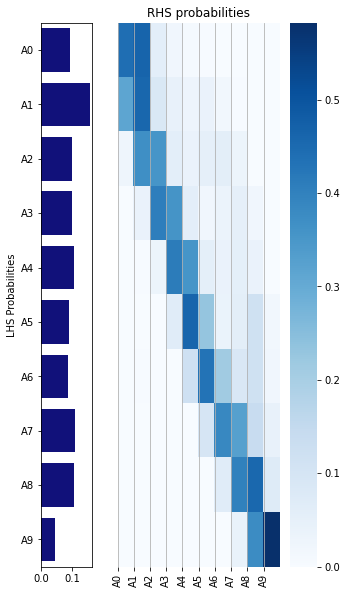

In [30]:
pwfts.visualize_distributions(model1)

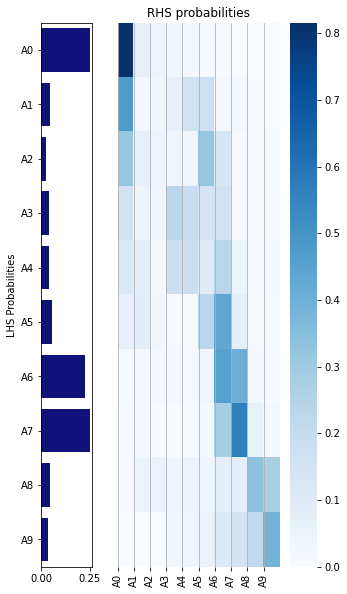

In [31]:
pwfts.visualize_distributions(model2)

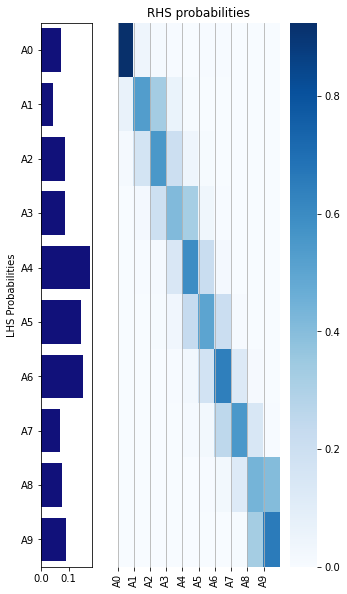

In [32]:
pwfts.visualize_distributions(model3)

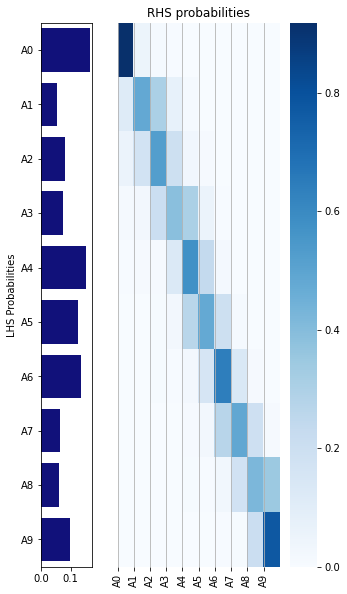

In [33]:
pwfts.visualize_distributions(model4)

In [34]:
#dataset = pd.read_excel('../content/sample_data/Base.xlsx')
#x = dataset.iloc[:,:-1].values
#y = dataset.iloc[:,-1].values
x = BaseT4[:,:-1]
y = BaseT4[:,-1]

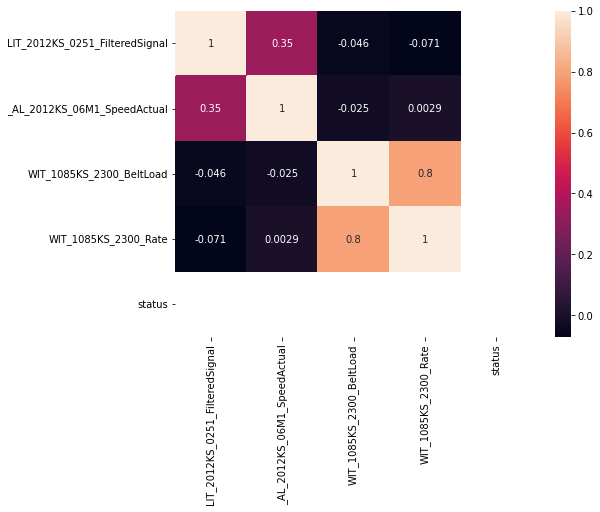

In [35]:
import seaborn as sns
#dataset2 = pd.read_excel('../content/sample_data/Base.xlsx')
corr_df = dff.corr(method='pearson')

plt.figure(figsize=(8, 6))
sns.heatmap(corr_df, annot=True)
plt.show()

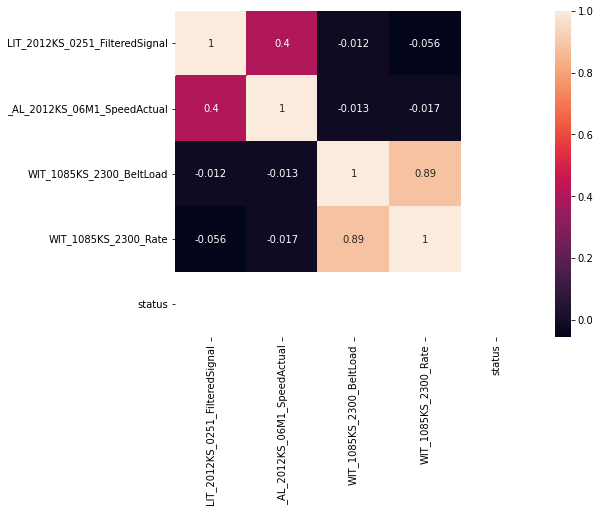

In [36]:
import seaborn as sns
#dataset2 = pd.read_excel('../content/sample_data/Base.xlsx')
corr_df = dfn.corr(method='pearson')

plt.figure(figsize=(8, 6))
sns.heatmap(corr_df, annot=True)
plt.show()

In [37]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x , y, test_size = 0.2, random_state = 10)

In [38]:
from xgboost import XGBClassifier
Classifier = XGBClassifier()
Classifier.fit(x_train, y_train)

XGBClassifier()

Matriz de confusão

In [39]:
from sklearn.metrics import confusion_matrix, accuracy_score
ypred = Classifier.predict(x_test)
cm = confusion_matrix(y_test, ypred)
print(cm)

[[47  0]
 [ 1 43]]


#Precisão

In [40]:
accuracy_score(y_test, ypred)

0.989010989010989

In [41]:
from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(estimator = Classifier, X = x_train, y = y_train, cv = 2)

print(accuracies.mean()*100)
print(accuracies.std()*100)

93.88888888888889
1.6666666666666663


##Predição com Classificação

In [42]:
#Impórtando os novos arquivos para realizar a classificação dos mesmos, porem com horizonte predito. Representando predição
#1- Importar arquivos
#2- Realizar predição a 100 e a 200 passos a frente(Intervalos de tempo aceitáveis)
#3- Obter pesos e regras da PWFTS
#4- Aplicar no Classificador já treinado anteriormente.

dPredicaoNormal = pd.read_excel('../content/drive/MyDrive/DadosPWFTS/PrevNormal.xlsx')
dPredicaoFalha = pd.read_excel('../content/drive/MyDrive/DadosPWFTS/PrevFalha.xlsx')

N200passos = 200
N100passos = 100

In [43]:
#Dados normais - sem falhas
from pyFTS.data import TAIEX, Malaysia, sunspots, artificial
from statsmodels.tsa.stattools import acf, pacf

datasets5 = {}

datasets5['LIT'] = dPredicaoNormal.get('LIT')
datasets5['SpeedActual'] = dPredicaoNormal.get('SpeedActual')
datasets5['BeltLoad'] = dPredicaoNormal.get('BeltLoad')
datasets5['Rate'] = dPredicaoNormal.get('Rate')
datasets5['Status'] = dPredicaoNormal.get('Status')


Probabilistic FTS:
(0.0) A1,A10,A15 -> (0.493)A15, (0.507)A16
(0.0) A1,A10,A16 -> (0.493)A15, (0.507)A16
(0.0) A1,A11,A15 -> (0.493)A15, (0.507)A16
(0.0) A1,A11,A16 -> (0.493)A15, (0.507)A16
(0.0) A10,A1,A10 -> (0.481)A15, (0.519)A16
(0.0) A10,A1,A11 -> (0.481)A15, (0.519)A16
(0.0) A10,A15,A15 -> (0.495)A15, (0.505)A16
(0.0) A10,A15,A16 -> (0.495)A15, (0.505)A16
(0.0) A10,A16,A15 -> (0.495)A15, (0.505)A16
(0.0) A10,A16,A16 -> (0.495)A15, (0.505)A16
(0.0) A10,A2,A10 -> (0.481)A15, (0.519)A16
(0.0) A10,A2,A11 -> (0.481)A15, (0.519)A16
(0.0) A11,A15,A15 -> (0.495)A15, (0.505)A16
(0.0) A11,A15,A16 -> (0.495)A15, (0.505)A16
(0.0) A11,A16,A15 -> (0.495)A15, (0.505)A16
(0.0) A11,A16,A16 -> (0.495)A15, (0.505)A16
(0.0) A14,A14,A14 -> (0.006)A14, (0.994)A15, (0.0)A16
(0.0) A14,A14,A15 -> (0.005)A14, (0.994)A15, (0.001)A16
(0.0) A14,A14,A16 -> (0.0)A14, (0.832)A15, (0.168)A16
(0.0) A14,A15,A14 -> (0.005)A14, (0.995)A15, (0.0)A16
(0.0) A14,A15,A15 -> (0.005)A14, (0.991)A15, (0.005)A16
(0.0) A14,A

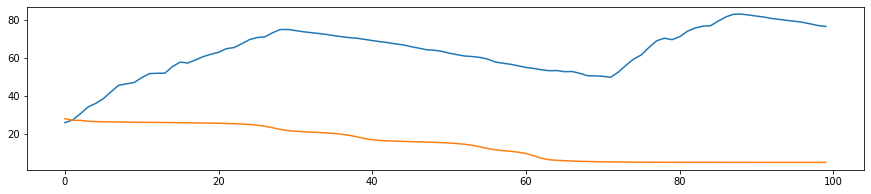

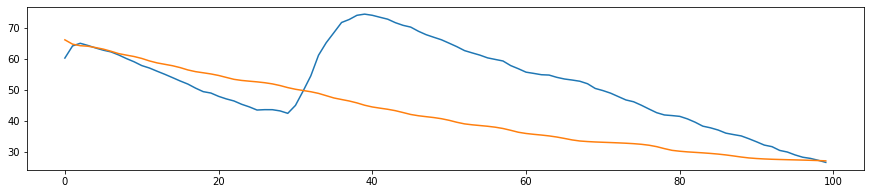

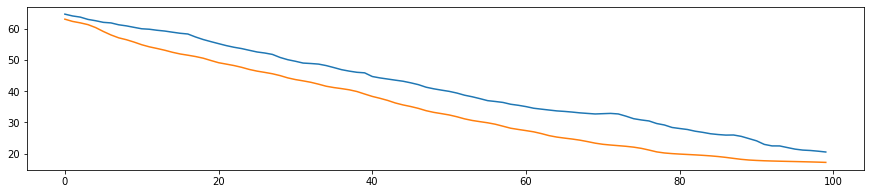

In [44]:
#Tratando os dados de nível
#Dados Com Falhas
from numpy.core.multiarray import concatenate
from pyFTS.models import pwfts
#from pyFTS.models import chen, cheng, hofts, pwfts
from pyFTS.partitioners import Grid
from pyFTS.benchmarks import Measures
from pyFTS.common import Util

#metodos = [chen.ConventionalFTS, cheng.TrendWeightedFTS, hofts.HighOrderFTS, 
#          hofts.WeightedHighOrderFTS, pwfts.ProbabilisticWeightedFTS]
metodos = [pwfts.ProbabilisticWeightedFTS]

k = 35#testar com 5000 dados e testar ordem 3
y1 = datasets5['LIT']
tam_grupo = 5000 #N100passos
#tam_grupo = N100passos
i=0
FoN = 0
#Validar variáveis
VU1=[]
V1_Markov =[]
V1T=[]
Bv1=[]

for i in range(0,y1.size,tam_grupo):
  grpan = y1[i:i+tam_grupo]
  part = Grid.GridPartitioner(data=np.asarray(grpan), npart=k)
  for contador, metodo in enumerate(metodos):
    model1 = metodo(partitioner=part, progress=False, type='distribution')
    if model1.is_high_order:
      model1 = metodo(partitioner=part, order=3)
    model1.fit(np.asarray(grpan))
    print(model1)  
    #Predicao
    PredictLIT = model1.predict(np.array(grpan),type='point', method='heuristic', steps_ahead=tam_grupo)
    PredV1 = PredictLIT
    #PredV1T = pd.concat(np.transpose(y1),PredV1)
    print(PredV1)#Vizualização dos valores previstos da variavael 1
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[15,3])
    ax.plot(np.array(grpan[:100]))
    ax.plot(PredV1[:100])
    #Com valores previstos Treinar novo Modelo
    partPred = Grid.GridPartitioner(data=np.asarray(PredV1), npart=k)
    model11 = pwfts.ProbabilisticWeightedFTS(partitioner=partPred, progress=False, type='distribution')
    model11.fit(np.asarray(PredV1))#Treinando novo modelo com os valores previstos 
    #print(model11)
  #Obtenção modelo de regras PWFTS
  _, _, lhs11, rhs11 = pwfts.highorder_fuzzy_markov_chain(model11)
  FoN=sum(grpan)
  print(lhs11)
  print(rhs11)
  lhs11t = np.transpose(lhs11)
  V1_Markov = np.c_[rhs11,lhs11t]
  print(i)
print(V1_Markov)

Probabilistic FTS:
(0.351) A0,A0 -> (0.981)A0, (0.014)A1, (0.001)A2, (0.0)A4, (0.001)A5, (0.001)A6, (0.0)A7, (0.0)A8, (0.002)A9
(0.008) A0,A1 -> (0.389)A0, (0.526)A1, (0.035)A2, (0.004)A3, (0.002)A4, (0.007)A6, (0.009)A7, (0.0)A8, (0.027)A9
(0.0) A0,A2 -> (0.001)A0, (0.093)A1, (0.137)A2, (0.181)A3, (0.057)A4, (0.025)A6, (0.232)A7, (0.009)A8, (0.266)A9
(0.0) A0,A4 -> (0.091)A5, (0.26)A6, (0.649)A9
(0.0) A0,A5 -> (0.175)A5, (0.602)A6, (0.003)A7, (0.22)A9
(0.0) A0,A6 -> (0.581)A6, (0.016)A7, (0.077)A8, (0.326)A9
(0.0) A0,A7 -> (0.197)A8, (0.803)A9
(0.0) A0,A8 -> (1.0)A9
(0.001) A0,A9 -> (1.0)A9
(0.005) A1,A0 -> (0.525)A0, (0.458)A1, (0.01)A2, (0.002)A6, (0.001)A7, (0.004)A9
(0.023) A1,A1 -> (0.083)A0, (0.668)A1, (0.245)A2, (0.001)A3, (0.0)A4, (0.0)A6, (0.0)A7, (0.0)A8, (0.002)A9
(0.011) A1,A2 -> (0.003)A0, (0.379)A1, (0.593)A2, (0.019)A3, (0.001)A4, (0.002)A6, (0.001)A7, (0.0)A8, (0.001)A9
(0.0) A1,A3 -> (0.004)A1, (0.307)A2, (0.236)A3, (0.204)A5, (0.044)A6, (0.205)A9
(0.0) A1,A4 -> (0.46

ZeroDivisionError: ignored

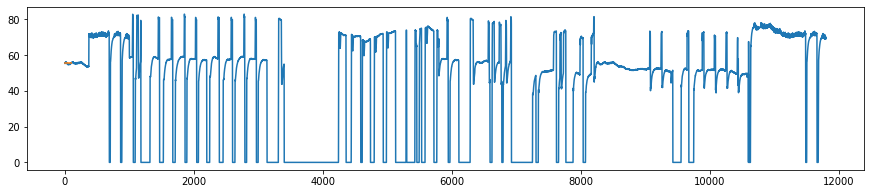

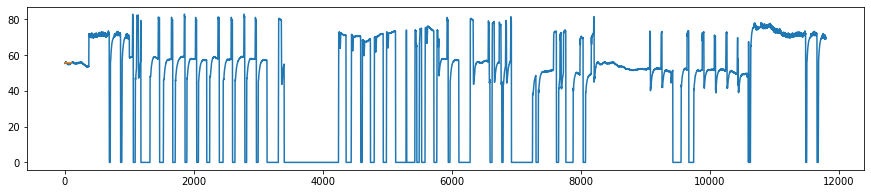

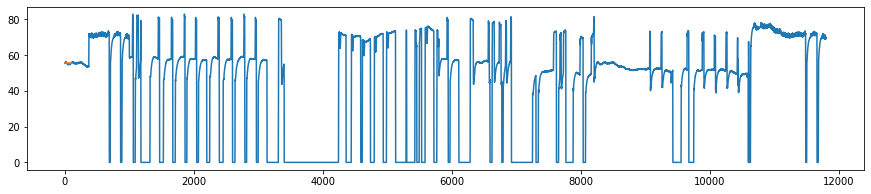

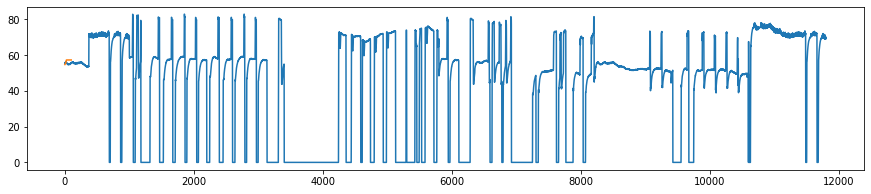

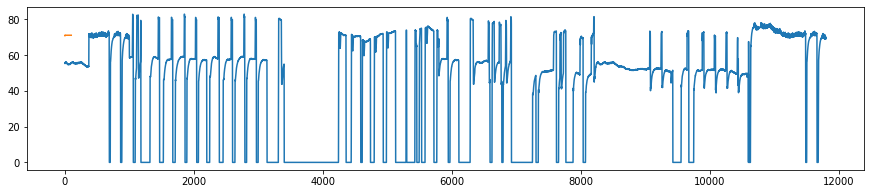

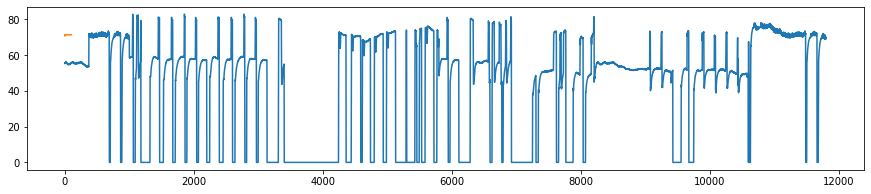

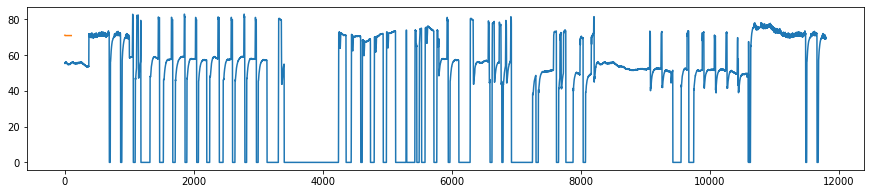

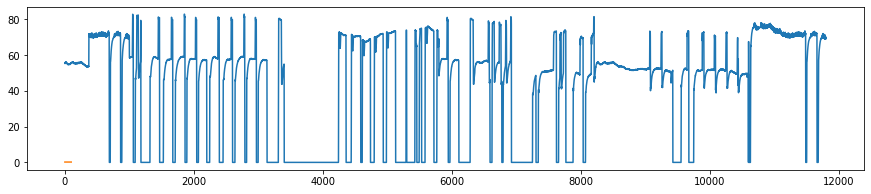

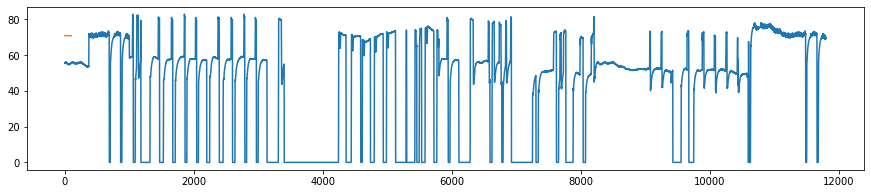

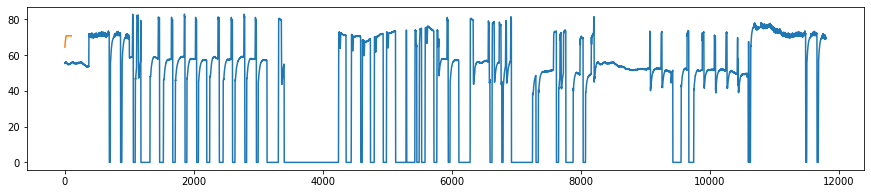

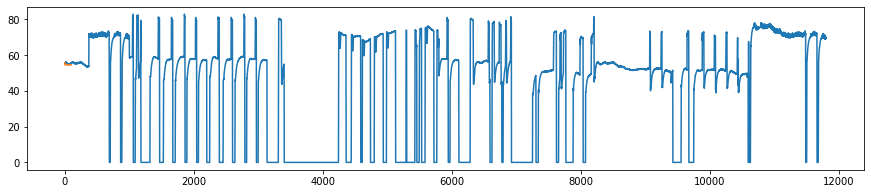

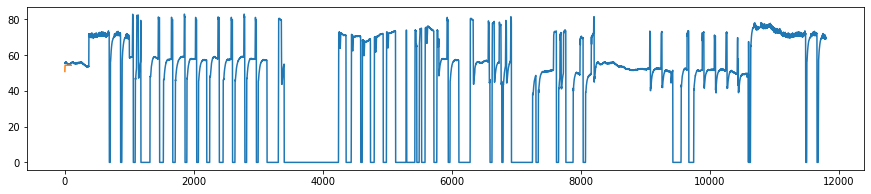

In [45]:
#Tratando os dados de nível
#Dados Com Falhas
from numpy.core.multiarray import concatenate
from pyFTS.models import pwfts
#from pyFTS.models import chen, cheng, hofts, pwfts
from pyFTS.partitioners import Grid
from pyFTS.benchmarks import Measures
from pyFTS.common import Util

#metodos = [chen.ConventionalFTS, cheng.TrendWeightedFTS, hofts.HighOrderFTS, 
#          hofts.WeightedHighOrderFTS, pwfts.ProbabilisticWeightedFTS]
metodos = [pwfts.ProbabilisticWeightedFTS]

k = 10
y2 = datasets5['SpeedActual']
tam_grupo = 100 #N100passos
#tam_grupo = N100passos
i=0
FoN = 0
#Validar variáveis
VU2=[]
V2_Markov =[]
V2T=[]

for i in range(0,y2.size,tam_grupo):
  grpan = y2[i:i+tam_grupo]
  part = Grid.GridPartitioner(data=np.asarray(grpan), npart=k)
  for contador, metodo in enumerate(metodos):
    model2 = metodo(partitioner=part, progress=False, type='distribution')
    if model2.is_high_order:
      model2 = metodo(partitioner=part, order=2)
    model2.fit(np.asarray(y2)) 
    print(model2) 
    #Predicao
    PredictSpeed = model2.predict(np.array(grpan),type='point', method='heuristic', steps_ahead=tam_grupo)
    PredV2 = PredictSpeed
    print(PredV2)#Vizualização dos valores previstos da variavael 
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[15,3])
    ax.plot(y2)
    ax.plot(PredV2)
    #Com valores previstos Treinar novo Modelo
    partPred = Grid.GridPartitioner(data=np.asarray(PredV2), npart=k)
    model22 = pwfts.ProbabilisticWeightedFTS(partitioner=partPred, progress=False, type='distribution')
    model22.fit(np.asarray(PredV2))#Treinando novo modelo com os valores previstos 
    print(model22)
  #Obtenção modelo de regras PWFTS
  _, _, lhs22, rhs22 = pwfts.highorder_fuzzy_markov_chain(model22)

  FoN=sum(grpan)
  lhs22t = np.transpose(lhs22)
  V2_Markov = np.c_[rhs22,lhs22t]
  print(i)
print(V2_Markov)

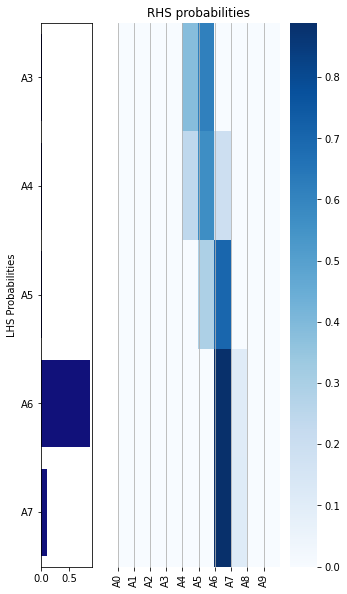

In [46]:
pwfts.visualize_distributions(model22)

Probabilistic FTS:
(0.001) A0,A0 -> (0.17)A0, (0.257)A1, (0.038)A2, (0.509)A3, (0.025)A4
(0.002) A0,A1 -> (0.118)A0, (0.389)A1, (0.085)A2, (0.383)A3, (0.026)A4
(0.001) A0,A2 -> (0.016)A0, (0.574)A1, (0.223)A2, (0.124)A3, (0.063)A4
(0.001) A0,A3 -> (0.074)A1, (0.514)A2, (0.351)A3, (0.061)A4
(0.0) A0,A4 -> (0.062)A1, (0.938)A2
(0.002) A1,A0 -> (0.253)A0, (0.496)A1, (0.123)A2, (0.124)A3, (0.004)A4
(0.014) A1,A1 -> (0.077)A0, (0.473)A1, (0.373)A2, (0.066)A3, (0.011)A4
(0.012) A1,A2 -> (0.011)A0, (0.371)A1, (0.459)A2, (0.121)A3, (0.038)A4
(0.002) A1,A3 -> (0.0)A0, (0.195)A1, (0.246)A2, (0.336)A3, (0.199)A4, (0.023)A5
(0.0) A1,A4 -> (0.008)A1, (0.125)A2, (0.692)A4, (0.174)A5
(0.001) A2,A0 -> (0.293)A0, (0.55)A1, (0.157)A2
(0.012) A2,A1 -> (0.061)A0, (0.506)A1, (0.381)A2, (0.044)A3, (0.008)A4
(0.017) A2,A2 -> (0.037)A0, (0.326)A1, (0.422)A2, (0.165)A3, (0.046)A4, (0.004)A5
(0.01) A2,A3 -> (0.006)A0, (0.07)A1, (0.174)A2, (0.307)A3, (0.373)A4, (0.069)A5, (0.0)A6
(0.004) A2,A4 -> (0.075)A2, (0.2

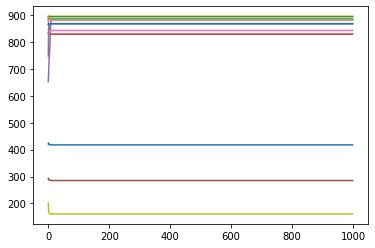

In [47]:
#Tratando os dados de nível
#Dados Com Falhas
from numpy.core.multiarray import concatenate
from pyFTS.models import pwfts
#from pyFTS.models import chen, cheng, hofts, pwfts
from pyFTS.partitioners import Grid
from pyFTS.benchmarks import Measures
from pyFTS.common import Util

#metodos = [chen.ConventionalFTS, cheng.TrendWeightedFTS, hofts.HighOrderFTS, 
#          hofts.WeightedHighOrderFTS, pwfts.ProbabilisticWeightedFTS]
metodos = [pwfts.ProbabilisticWeightedFTS]

k = 10
y3 = datasets5['BeltLoad']
tam_grupo = 1000 #N100passos
#tam_grupo = N100passos
i=0

#Validar variáveis
VU3=[]
V3_Markov =[]
V3T=[]

for i in range(0,y3.size,tam_grupo):
  grpan = y3[i:i+tam_grupo]#1000 amostras
  part = Grid.GridPartitioner(data=np.asarray(grpan), npart=k)
  for contador, metodo in enumerate(metodos):
    model3 = metodo(partitioner=part, progress=False, type='distribution')
    if model3.is_high_order:
      model3 = metodo(partitioner=part, order=2)
    model3.fit(np.asarray(grpan))
    print(model3)  
    #Predicao
    PredictBelt = model3.predict(np.array(grpan), type='point', method='heuristic', steps_ahead=tam_grupo)    
    PredV3 = PredictBelt
    print(PredV3)#Vizualização dos valores previstos da variavael 2
    plt.plot(PredV3)
    #Com valores previstos Treinar novo Modelo
    partPred = Grid.GridPartitioner(data=np.asarray(PredV3), npart=k)
    model33 = pwfts.ProbabilisticWeightedFTS(partitioner=partPred, progress=False, type='distribution')
    model33.fit(np.asarray(PredV3))#Treinando novo modelo com os valores previstos 
    print(model33)
    
  #Obtenção modelo de regras PWFTS
  _, _, lhs33, rhs33 = pwfts.highorder_fuzzy_markov_chain(model33)#Obtenção dos Pesos
  _, _, lhs3, rhs3 = pwfts.highorder_fuzzy_markov_chain(model3)#Obtenção dos Pesos

  print(lhs3)
  print(rhs3)
  FoN=sum(grpan)
  lhs33t = np.transpose(lhs33)
  V3_Markov = np.c_[rhs33,lhs33t]
  print(i)
print(V3_Markov)

In [48]:
print(len(model3))

67


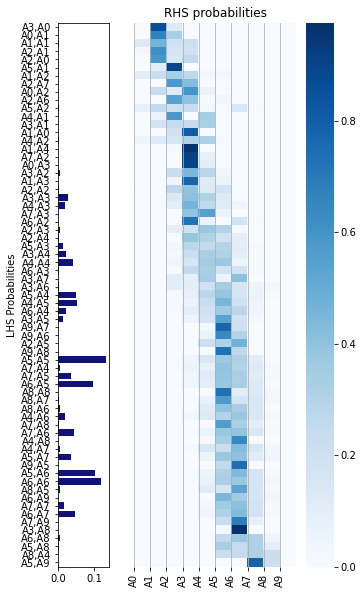

In [49]:
pwfts.visualize_distributions(model3)

[8189.9887664143935, 8570.226430076315, 8550.244647915915, 8468.582743889323, 8449.741387084867, 8459.669252436433, 8466.05120523176, 8465.978225254825, 8464.748601515823, 8464.41450089527, 8464.552508375784, 8464.654803327654, 8464.657585553081, 8464.639103257792, 8464.633197911297, 8464.635078887763, 8464.636769128003, 8464.636942190862, 8464.636587978144, 8464.636557919233, 8464.636571141767, 8464.636573272877, 8464.636572843836, 8464.636572725267, 8464.636572736028, 8464.636572741785, 8464.636572741694, 8464.636572741441, 8464.636572741429, 8464.63657274144, 8464.636572741441, 8464.63657274144, 8464.63657274144, 8464.636572741441, 8464.63657274144, 8464.63657274144, 8464.636572741441, 8464.63657274144, 8464.63657274144, 8464.636572741441, 8464.63657274144, 8464.63657274144, 8464.636572741441, 8464.63657274144, 8464.63657274144, 8464.636572741441, 8464.63657274144, 8464.63657274144, 8464.636572741441, 8464.63657274144, 8464.63657274144, 8464.636572741441, 8464.63657274144, 8464.6365

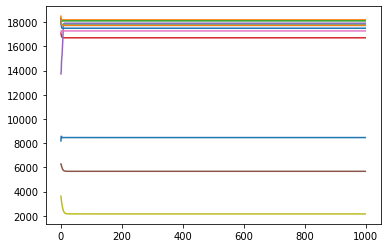

In [50]:
#Tratando os dados de nível
#Dados Com Falhas
from numpy.core.multiarray import concatenate
from pyFTS.models import pwfts
#from pyFTS.models import chen, cheng, hofts, pwfts
from pyFTS.partitioners import Grid
from pyFTS.benchmarks import Measures
from pyFTS.common import Util

#metodos = [chen.ConventionalFTS, cheng.TrendWeightedFTS, hofts.HighOrderFTS, 
#          hofts.WeightedHighOrderFTS, pwfts.ProbabilisticWeightedFTS]
metodos = [pwfts.ProbabilisticWeightedFTS]

k = 10
y4 = datasets5['Rate']
tam_grupo = 1000 #N100passos
#tam_grupo = N100passos
i=0
FoN = 0 
#Validar variáveis
VU4=[]
V4_Markov =[]
V4T=[]

for i in range(0,y4.size,tam_grupo):
  grpan = y4[i:i+tam_grupo]
  part = Grid.GridPartitioner(data=np.asarray(grpan), npart=k)
  for contador, metodo in enumerate(metodos):
    model4 = metodo(partitioner=part, progress=False, type='distribution')
    if model4.is_high_order:
      model4 = metodo(partitioner=part, order=2)
    model4.fit(np.asarray(grpan))  
    #Predicao
    PredictRate = model4.predict(np.array(grpan),type='point', method='heuristic', steps_ahead=tam_grupo)
    PredV4 = PredictRate
    print(PredV4)#Vizualização dos valores previstos da variavael 1
    plt.plot(PredV4)
      #Com valores previstos Treinar novo Modelo
    partPred = Grid.GridPartitioner(data=np.asarray(PredV4), npart=k)
    model44 = pwfts.ProbabilisticWeightedFTS(partitioner=partPred, progress=False, type='distribution')
    model44.fit(np.asarray(PredV4))#Treinando novo modelo com os valores previstos 
  #Obtenção modelo de regras PWFTS
  FOS, OS, lhs44, rhs44 = pwfts.highorder_fuzzy_markov_chain(model44)#Obtenção dos Pesos

  FoN=sum(grpan)
  lhs44t = np.transpose(lhs44)
  V4_Markov = np.c_[rhs44,lhs44t]
  print(i)
print(V4_Markov)

In [51]:
trainM = (np.asarray(datasets5)).iloc[:700,:]
testM = datasets5.iloc[700:,:]

AttributeError: ignored

In [ ]:
ytst11 = np.ones(60)
ytst22 = np.zeros(0)
ytstt = np.concatenate((ytst11,ytst22))

In [ ]:
BaseTT1 = np.transpose(np.concatenate([np.transpose(V1_Markov),np.transpose(V2_Markov),np.transpose(V3_Markov),np.transpose(V4_Markov)]))
BaseT4 = np.c_[np.transpose(BaseTT1),ytstt]

In [ ]:
x = BaseT4[:,:-1]
y = BaseT4[:,-1]

In [52]:
from sklearn.metrics import confusion_matrix, accuracy_score
ypred = Classifier.predict(x)
cm = confusion_matrix(y, ypred)
print(cm)

[[253   0]
 [  1 197]]


###Análise de CCF

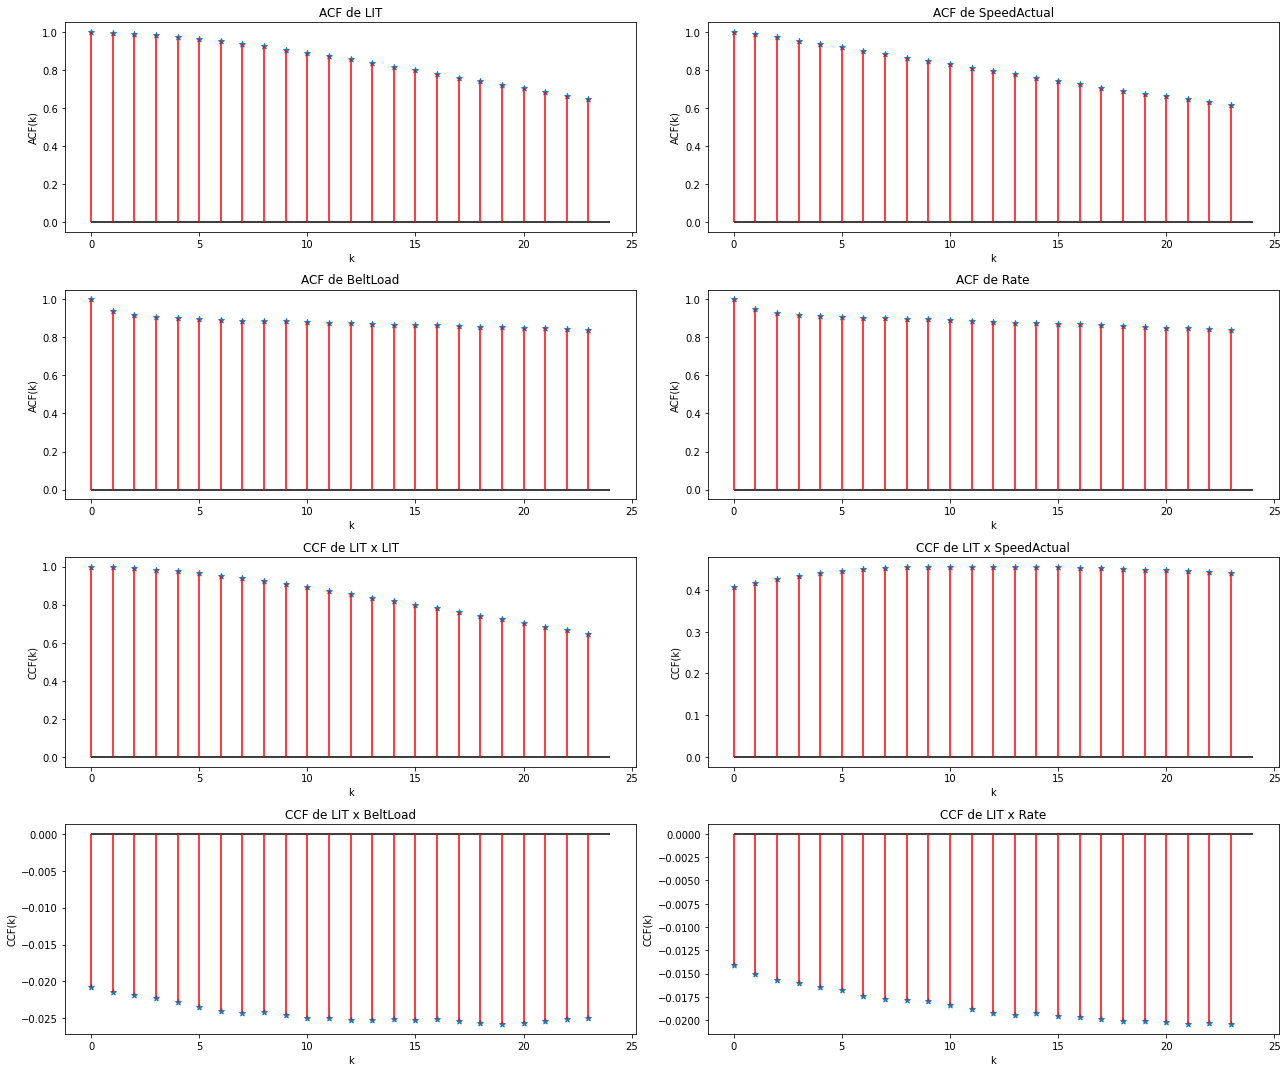

In [61]:
fig, ax = plt.subplots(nrows=4, ncols=2,figsize=[18,15])

ax[0][0].set_title('ACF de LIT')
plot_acf(datasets5['LIT'].values, 24, axis=ax[0][0])
ax[0][1].set_title('ACF de SpeedActual')
plot_acf(datasets5['SpeedActual'].values, 24, axis=ax[0][1])
ax[1][0].set_title('ACF de BeltLoad')
plot_acf(datasets5['BeltLoad'].values, 24, axis=ax[1][0])
ax[1][1].set_title('ACF de Rate')
plot_acf(datasets5['Rate'].values, 24, axis=ax[1][1])
ax[2][0].set_title('CCF de LIT x LIT')
plot_ccf(datasets5['LIT'].values, datasets5['LIT'].values, 24, axis=ax[2][0])
ax[2][1].set_title('CCF de LIT x SpeedActual')
plot_ccf(datasets5['LIT'].values, datasets5['SpeedActual'].values, 24, axis=ax[2][1])
ax[3][0].set_title('CCF de LIT x BeltLoad')
plot_ccf(datasets5['LIT'].values, datasets5['BeltLoad'].values, 24, axis=ax[3][0])
ax[3][1].set_title('CCF de LIT x Rate')
plot_ccf(datasets5['LIT'].values, datasets5['Rate'].values, 24, axis=ax[3][1])

plt.tight_layout()

In [53]:
#from nsepy import get_history
import datetime
from datetime import date
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
#from nsepy.derivatives import get_expiry_date

In [54]:
def Var(X):
  n = len(X)
  mx = np.mean(X)
  c = np.mean([(x - mx)**2 for x in X])
  return c

def AutoCov(X, k):
  n = len(X)
  mx = np.mean(X)
  c = np.zeros(n-k)
  for i in range(n - k):
    c[i] = (X[i] - mx)*(X[i+k] - mx)
  c = c.mean()
  
  return c

def CrossCov(X, Y, k):
  n = len(X)
  mx = np.mean(X)
  my = np.mean(Y)
  c = np.zeros(n-k)
  for i in range(n - k):
    c[i] = (X[i] - mx)*(Y[i+k] - my)
  c = c.mean()
  
  return c

def ACF(X, k):
  gamma_k = AutoCov(X, k)
  gamma_0 = Var(X)
  return gamma_k / gamma_0

def CCF(X, Y, k):
  gamma_xy = CrossCov(X, Y, k)
  gamma_x = Var(X)
  gamma_y = Var(Y)
  return gamma_xy / np.sqrt(gamma_x * gamma_y)

In [55]:
def plot_acf(X, k, **kwargs):
  acf = []
  for i in range(k):
    acf.append(ACF(X, i))

  ax = kwargs.get("axis", None)
  if ax is None:
    fig, ax = plt.subplots(nrows=1, ncols=1,figsize=[10,5])

  ax.hlines([0],[0],[k], color="black")
  ax.vlines([i for i in range(k)], [0 for i in range(k)], acf, color="red")
  ax.scatter([i for i in range(k)], acf, marker="*")
  ax.set_xlabel("k")
  ax.set_ylabel("ACF(k)")

def plot_ccf(X, Y, k, **kwargs):
  ccf = []
  for i in range(k):
    ccf.append(CCF(X, Y,  i))

  ax = kwargs.get("axis", None)
  if ax is None:
    fig, ax = plt.subplots(nrows=1, ncols=1,figsize=[10,5])

  ax.hlines([0],[0],[k], color="black")
  ax.vlines([i for i in range(k)], [0 for i in range(k)], ccf, color="red")
  ax.scatter([i for i in range(k)], ccf, marker="*")
  ax.set_xlabel("k")
  ax.set_ylabel("CCF(k)")